# Baseline MNIST

In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy.special import softmax
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
import vbranch as vb

In [3]:
save = False
model_id = 1
architecture = 'fcn'

## Load Data

In [4]:
num_classes = 10
(X_train, y_train_one_hot), (X_test, y_test_one_hot) = vb.datasets.mnist.load_data(format=architecture)

In [5]:
input_shape = X_train.shape[1:]
print(input_shape)

(784,)


## Build Model

In [6]:
BATCH_SIZE = 32
EPOCHS = 15
STEPS_PER_EPOCH = 100
model_path = './models/mnist-{}_{}'.format(architecture, model_id)

In [7]:
tf.reset_default_graph()

x = tf.placeholder('float32', (None,) + input_shape, name='x')
y = tf.placeholder('float32', [None, num_classes], name='y')

batch_size = tf.placeholder('int64', name='batch_size')

dataset = tf.data.Dataset.from_tensor_slices((x,y)).\
    batch(batch_size).repeat().\
    shuffle(buffer_size=4*BATCH_SIZE)

iter_ = dataset.make_initializable_iterator()
inputs, labels_one_hot = iter_.get_next('input')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def build_model(architecture, inputs, labels, num_classes,model_id,test=False):
    if architecture == 'fcn':
        model = vb.simple_fcn(inputs,512,num_classes,
            name='model_'+str(model_id))
    elif architecture == 'cnn':
        model = vb.simple_cnn(inputs,num_classes,16,32,
            name='model_'+str(model_id))
    else:
        raise ValueError('Invalid architecture')

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    model.compile(optimizer, 'softmax_cross_entropy_with_logits',
                    labels_one_hot=labels, test=test)
    model.summary()
    return model

In [9]:
model = build_model(architecture, inputs, labels_one_hot, num_classes, model_id)

Instructions for updating:
Use tf.cast instead.
i  Layer name  Output shape  Parameters        Num param  Inbound  
-------------------------------------------------------------------
   Input       [None,784]                                          
-------------------------------------------------------------------
0  fc1         [None,512]    [784,512] [512]   401920     input:0  
-------------------------------------------------------------------
1  bn1         [None,512]    [512] [512]       1024       fc1      
-------------------------------------------------------------------
2  relu1       [None,512]                      0          bn1      
-------------------------------------------------------------------
3  output      [None,10]     [512,10] [10]     5130       relu1    
-------------------------------------------------------------------
Total parameters: 408074


In [10]:
# Build copy of model for testing
x_test = tf.placeholder('float32', (None,) + input_shape, name='x_test')
y_test = tf.placeholder('float32', [None, num_classes], name='y_test')
test_model = build_model(architecture, x_test, y_test,num_classes,model_id, test=True)

i  Layer name  Output shape  Parameters        Num param  Inbound   
--------------------------------------------------------------------
   Input       [None,784]                                           
--------------------------------------------------------------------
0  fc1         [None,512]    [784,512] [512]   401920     x_test:0  
--------------------------------------------------------------------
1  bn1         [None,512]    [512] [512]       1024       fc1       
--------------------------------------------------------------------
2  relu1       [None,512]                      0          bn1       
--------------------------------------------------------------------
3  output      [None,10]     [512,10] [10]     5130       relu1     
--------------------------------------------------------------------
Total parameters: 408074


In [11]:
history = model.fit(iter_, X_train, y_train_one_hot, EPOCHS, STEPS_PER_EPOCH, BATCH_SIZE, 
                    validation=(X_test, y_test_one_hot), test_model=test_model)

Epoch 1/15
 - 1s - train_loss: 0.4782 - train_acc: 0.8588 - val_acc: 0.9151 - val_loss: 0.2851
Epoch 2/15
 - 1s - train_loss: 0.2110 - train_acc: 0.9456 - val_acc: 0.9227 - val_loss: 0.2514
Epoch 3/15
 - 1s - train_loss: 0.1635 - train_acc: 0.9566 - val_acc: 0.9271 - val_loss: 0.2300
Epoch 4/15
 - 1s - train_loss: 0.1142 - train_acc: 0.9691 - val_acc: 0.9332 - val_loss: 0.2172
Epoch 5/15
 - 1s - train_loss: 0.0819 - train_acc: 0.9828 - val_acc: 0.9392 - val_loss: 0.2043
Epoch 6/15
 - 1s - train_loss: 0.0640 - train_acc: 0.9862 - val_acc: 0.9383 - val_loss: 0.2053
Epoch 7/15
 - 1s - train_loss: 0.0536 - train_acc: 0.9894 - val_acc: 0.9376 - val_loss: 0.2067
Epoch 8/15
 - 1s - train_loss: 0.0373 - train_acc: 0.9934 - val_acc: 0.9420 - val_loss: 0.1904
Epoch 9/15
 - 1s - train_loss: 0.0349 - train_acc: 0.9934 - val_acc: 0.9402 - val_loss: 0.1960
Epoch 10/15
 - 1s - train_loss: 0.0178 - train_acc: 0.9981 - val_acc: 0.9452 - val_loss: 0.1817
Epoch 11/15
 - 1s - train_loss: 0.0223 - train_ac

## Model Ensemble

In [66]:
test_outputs = []
test_losses = []
test_accs = []

num_models = 4
graphs = [tf.Graph() for _ in range(5)]
sessions = [tf.Session(graph=g) for g in graphs]

for i in np.random.choice(5, num_models, replace=False): # range(len(graphs)):
    with graphs[i].as_default():
        model_path = './models/mnist-{}_{}'.format(architecture, i + 1)
        meta_path = os.path.join(model_path, 'ckpt.meta')
        ckpt = tf.train.get_checkpoint_state(model_path)
        
        imported_graph = tf.train.import_meta_graph(meta_path)
        imported_graph.restore(sessions[i], ckpt.model_checkpoint_path)
                
        sessions[i].run('test_init_op', feed_dict={'batch_size:0': len(X_test)})
        
        output, loss, acc = sessions[i].run(['model_%d'%(i+1)+'/'+'output:0', 
                                             'loss:0', 'acc:0'])
        test_outputs.append(output)
        test_losses.append(loss)
        test_accs.append(acc)

INFO:tensorflow:Restoring parameters from ./models/mnist_5/ckpt
INFO:tensorflow:Restoring parameters from ./models/mnist_2/ckpt
INFO:tensorflow:Restoring parameters from ./models/mnist_1/ckpt
INFO:tensorflow:Restoring parameters from ./models/mnist_4/ckpt


In [67]:
test_accs

[0.944, 0.9465, 0.9472, 0.9471]

In [68]:
def compute_acc(pred, labels_one_hot):
    pred_max = tf.keras.utils.to_categorical(np.argmax(pred, axis=-1), num_classes)
    return np.mean(np.sum(labels_one_hot*pred_max, axis=1))

In [69]:
for i in range(num_models):
    assert compute_acc(test_outputs[i], y_test_one_hot) == test_accs[i]

### Average Predictions Before Softmax

In [70]:
before_mean_output = np.array(test_outputs).mean(axis=0)
before_mean_acc = compute_acc(softmax(before_mean_output, axis=-1), y_test_one_hot)

In [71]:
print(before_mean_acc)

0.9536


### Average Predictions After Softmax

In [72]:
after_mean_output = softmax(np.array(test_outputs), axis=-1).mean(axis=0)
after_mean_acc = compute_acc(softmax(after_mean_output, axis=-1), y_test_one_hot)

In [73]:
print(after_mean_acc)

0.9539


## Feature Visualization

In [18]:
with tf.Session() as sess:
    model_path = os.path.join('models', 'mnist-{}_{}'.format(architecture,model_id))
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

    sample_size = 250
    sess.run('test_init_op', feed_dict={'batch_size:0':sample_size})
    X_test_samples, y_test_samples, features = sess.run(['input:0', 'input:1', 
                                                         'model_'+str(model_id)+'/output:0'])

INFO:tensorflow:Restoring parameters from models/mnist-cnn_1/ckpt


In [23]:
start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.001s...
[t-SNE] Computed neighbors for 250 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 5.143837
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.256058
[t-SNE] KL divergence after 300 iterations: 0.292163
t-SNE done! Time elapsed: 0.5325720310211182 seconds


In [28]:
labels = np.argmax(y_test_samples, axis=-1)

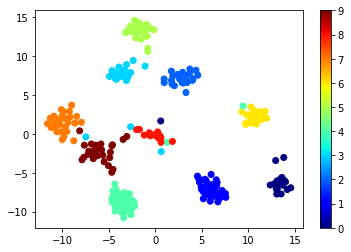

In [29]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap=plt.cm.jet)
plt.colorbar()
plt.show()